In [1]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions
using StatsBase
using Alert

In [2]:
function OUH(x0::Float64,γ::Float64,t::AbstractArray,Δt::Float64,η::Float64,cte::Float64=0.0) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0    #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck
    
    for i=1:length(t)-1                 #Usamos un for para poder hacer el proceso
        x0=x0-γ*Δt*(x0-cte)+(sqrt(2*η*Δt)*randn()) # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x                          # Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 2 methods)

In [3]:
U(K::Float64,T::Float64)=[T/sqrt(K^2+T^2),0,K/sqrt(K^2+T^2)] #Es la función que da el eje de rotación dependiente de la curvatura y la torsión
ϕ(K::Float64,T::Float64,Δt::Float64)=Δt*sqrt(K^2+T^2) #Es la función que da el angulo de rotación

ψ0(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar el primer angulo  resultado de dos "matrices/cuaternios"

# Son las funciones para generar el primer eje resultado de dos "matrices/cuaternios"
w1x(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1])*csc(ψ0/2) 
w1y(ϕ0,ϕ1,u,w,ψ0)=((u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
w1z(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3])*csc(ψ0/2)


ψn(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar los otros angulos

# Son las funciones para generar los otros ejes resultado
wnx(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1]-(w[2]*u[3])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)
wny(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[2]+(u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
wnz(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3]+(w[2]*u[1])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)


wnz (generic function with 1 method)

In [4]:
#Acomodamos el eje y el angulo de rotacion en una matriz de euler-rodriguez

MatRot(ω,Ψ)=[ cos(Ψ)+ω[1]^2*(1-cos(Ψ)) ω[1]*ω[2]*(1-cos(Ψ))-ω[3]*sin(Ψ) ω[1]*ω[3]*(1-cos(Ψ))+ω[2]*sin(Ψ);
                ω[2]*ω[1]*(1-cos(Ψ))+ω[3]*sin(Ψ) cos(Ψ)+ω[2]^2*(1-cos(Ψ)) ω[2]*ω[3]*(1-cos(Ψ))-ω[1]*sin(Ψ);
                    ω[3]*ω[1]*(1-cos(Ψ))-ω[2]*sin(Ψ) ω[3]*ω[2]*(1-cos(Ψ))+ω[1]*sin(Ψ) cos(Ψ)+ω[3]^2*(1-cos(Ψ))]

MatRot (generic function with 1 method)

In [5]:
function eigenf_v(tiradas::Int64,PASO::Int64) # Es la función que nos da los eigenejes o eigenvectores de un ensabmble


    v=Array{Array{Float64,1},1}(undef,tiradas)    #Es una lista vacia donde irán todos los eigenejes

    for j=1:tiradas                               #En este for se scara n=tiradas ejes 

        K=OUH(k0,γK,t[1:PASO],Δt,ηK,ctek)         #En cada for se obtiene un proceso de Ornstein–Uhlenbeck diferente
        T=OUH(t0,γT,t[1:PASO],Δt,ηT,ctet)

        Un=U.(K,T)                                #Se obtiene los ejes infinitesimales
        ϕn=ϕ.(K,T,Δt)                             #Se obtiene los ángulos infinitesimales

        ω=Array{Array{Float64,1},1}(undef,PASO)   #se pondrán aquí los eigenejes en cada paso
        Ψ=Array{Float64,1}(undef,PASO)            #se pondrán aquí los eigenfases en cada paso
        ω[1]=Un[1]                                #se coloca el primer eje
        Ψ[1]=ϕn[1]                                #se coloca la primer fase

        ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])            #Se construye la segunda fase
        w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),       #Se construye el segundo eje
            w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
            w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
        ω[2]=w                                  #Se coloca el segundo eje
        Ψ[2]=ψ1                                 #Se coloca el segundo angulo 
        for i=3:PASO                            # Se construyen y colocan los demas hasta cierto paso
            ψ=ψn(ψ1,ϕn[i],Un[i],w)
            w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)]
            ω[i]=w
            Ψ[i]=ψ1
            ψ1=ψ
        end
        v[j]=ω[end]           #Solo se agrega el último eigen eje para ver como se ven los ultimos ejes
    end
    return v
end

eigenf_v (generic function with 1 method)

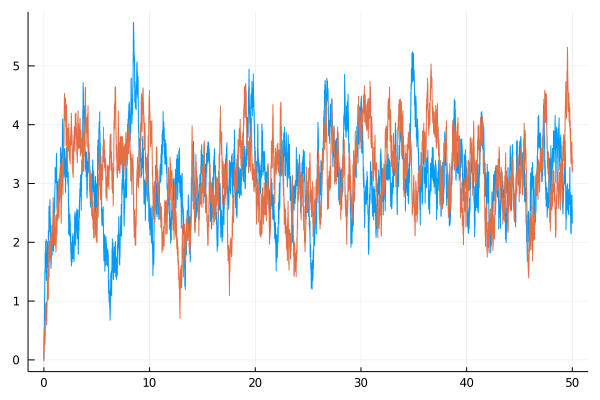

In [26]:
k0=0.01
t0=0.01

γK=2.0
γT=2.0

ηK=1.0
ηT=1.0

N=50.0

Δt=0.001

t=0:Δt:N

ctek=3.0
ctet=3.0

K=OUH(k0,γK,t,Δt,ηK,ctek)
T=OUH(t0,γT,t,Δt,ηT,ctet)
plot(t,K,legend=false)
plot!(t,T,legend=false)

In [36]:
tiradas=5000
PASO=length(t)
println(PASO)
#PASO=4001

50001


In [37]:
@time v=eigenf_v(tiradas,PASO);

611.317449 seconds (5.48 G allocations: 148.790 GiB, 3.11% gc time)


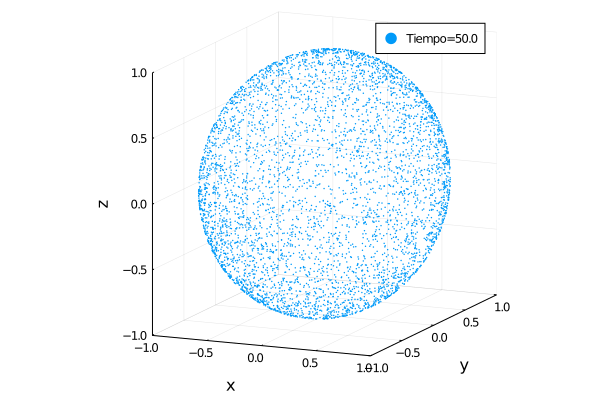

In [38]:
scatter(transpose(hcat(v...))[:,3],transpose(hcat(v...))[:,2],transpose(hcat(v...))[:,1],
    markersize=1,xlims=(-1,1),ylims=(-1,1),zlims=(-1,1),aspect_ratio=:equal,markershape=:circle,label="Tiempo=$(t[PASO])"
    ,markerstrokewidth=0,xlabel="x",ylabel="y",zlabel="z")

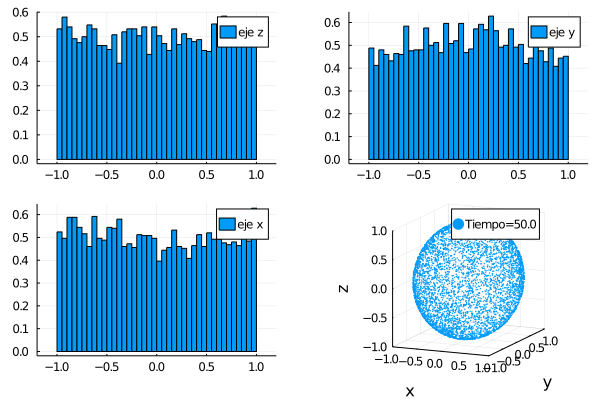

In [39]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=histogram(transpose(hcat(v...))[:,3],bins=60,normalized=true,xlims=(-1.2,1.2),label="eje z")
Q2=histogram(transpose(hcat(v...))[:,2],bins=60,normalized=true,xlims=(-1.2,1.2),label="eje y")
Q3=histogram(transpose(hcat(v...))[:,1],bins=60,normalized=true,xlims=(-1.2,1.2),label="eje x")
Q4=scatter(transpose(hcat(v...))[:,1],transpose(hcat(v...))[:,2],transpose(hcat(v...))[:,3],markersize=1,xlims=(-1,1),ylims=(-1,1),zlims=(-1,1)
    ,aspect_ratio=:equal,xlabel="x",ylabel="y",zlabel="z",label="Tiempo=$(t[PASO])",markerstrokewidth=0)
plot(Q1,Q2,Q3,Q4,layout=l)

In [40]:
savefig("./Eigen_ejes_Paso_4.png")

In [41]:
step=100
length(t)
length(2:step:length(t))

500

In [ ]:
@time begin
    anim= @animate for k=2:step:length(t)
        tiradas=100
        PASO=k
        v=eigenf_v(tiradas,PASO);
        l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
        Q1=histogram(transpose(hcat(v...))[:,3],bins=60,normalized=true,ylims=(0,5),xlims=(-1.2,1.2),label="eje z")
        Q2=histogram(transpose(hcat(v...))[:,2],bins=60,normalized=true,ylims=(0,5),xlims=(-1.2,1.2),label="eje y")
        Q3=histogram(transpose(hcat(v...))[:,1],bins=60,normalized=true,ylims=(0,5),xlims=(-1.2,1.2),label="eje x")
        Q4=scatter(transpose(hcat(v...))[:,1],transpose(hcat(v...))[:,2],transpose(hcat(v...))[:,3],markersize=1,xlims=(-1,1),ylims=(-1,1),zlims=(-1,1),aspect_ratio=:equal,xlabel="x",ylabel="y",zlabel="z",label="Tiempo=$(t[k])")
        plot(Q1,Q2,Q3,Q4,layout=l)
    end
    gif(anim,"./EJES_FINAL.gif", fps=60)
end